ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 26.4 MB/s eta 0:00:00


CN1CCC2=CC=CC=C2C1




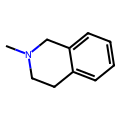

In [1]:
!pip install pandas numpy rdkit-pypi xgboost scikit-learn joblib Pillow ipython
!pip install rdkit

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, Draw
from xgboost import XGBClassifier
import joblib
import warnings
from IPython.display import display, HTML
import io
import base64

warnings.filterwarnings('ignore')

# Ultra-compact display settings
display(HTML("<style>.container { width: 95% !important; margin: 0 auto; }</style>"))
display(HTML("<style>div.output_scroll { height: auto; max-height: 200px; }</style>"))

# Professional Scientific Color Scheme
COLORS = {
    'primary': '#2E5B88',
    'accent1': '#7CB4B8',
    'accent2': '#E76F51',
    'accent3': '#2A9D8F',
    'text': '#2D3748',
    'background': '#F8F9FA',
    'border': '#E2E8F0',
}

# Compact header
display(HTML(f"""
<div style="background: {COLORS['primary']};
            padding: 6px;
            border-radius: 3px;
            text-align: center;
            margin-bottom: 6px;">
    <h1 style="color: white;
               font-size: 1.1em;
               font-weight: 600;
               margin: 0;">
        5-HT1A-LiCAs (5-HT1A Ligand Classification and Screening Tool)
    </h1>
</div>
"""))

class MolecularDescriptorCalculator:
    def __init__(self):
        self.fpgen = AllChem.GetMorganGenerator(radius=2, fpSize=2048)

    def calculate_morgan_fingerprints(self, mol):
        try:
            fp = self.fpgen.GetFingerprint(mol)
            return {f'fp_bit_{i}': fp.GetBit(i) for i in range(2048)}
        except Exception:
            return {f'fp_bit_{i}': 0 for i in range(2048)}

    def calculate_2d_descriptors(self, mol):
        desc_dict = {}
        try:
            for desc_name, desc_func in Descriptors.descList:
                try:
                    value = desc_func(mol)
                    desc_dict[desc_name] = 0.0 if value is None or (isinstance(value, float) and np.isnan(value)) else value
                except Exception:
                    desc_dict[desc_name] = 0.0
            return desc_dict
        except Exception:
            return {}

    def calculate_3d_descriptors(self, mol):
        try:
            mol_3d = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol_3d, randomSeed=42)
            AllChem.MMFFOptimizeMolecule(mol_3d)

            desc_dict = {
                'PMI1': rdMolDescriptors.CalcPMI1(mol_3d),
                'PMI2': rdMolDescriptors.CalcPMI2(mol_3d),
                'PMI3': rdMolDescriptors.CalcPMI3(mol_3d),
                'RadiusOfGyration': rdMolDescriptors.CalcRadiusOfGyration(mol_3d),
                'InertialShapeFactor': rdMolDescriptors.CalcInertialShapeFactor(mol_3d),
                'Eccentricity': rdMolDescriptors.CalcEccentricity(mol_3d),
                'Asphericity': rdMolDescriptors.CalcAsphericity(mol_3d),
                'SpherocityIndex': rdMolDescriptors.CalcSpherocityIndex(mol_3d),
                'PBF': rdMolDescriptors.CalcPBF(mol_3d),
            }

            desc_dict['NPR1'] = desc_dict['PMI1'] / desc_dict['PMI3'] if desc_dict['PMI3'] != 0 else 0
            desc_dict['NPR2'] = desc_dict['PMI2'] / desc_dict['PMI3'] if desc_dict['PMI3'] != 0 else 0

            return desc_dict
        except Exception:
            return {key: 0.0 for key in ['PMI1', 'PMI2', 'PMI3', 'NPR1', 'NPR2', 'RadiusOfGyration',
                                        'InertialShapeFactor', 'Eccentricity', 'Asphericity',
                                        'SpherocityIndex', 'PBF']}

    def get_molecule_image(self, mol):
        """Get molecule structure as base64 for proper centering"""
        try:
            Chem.rdDepictor.Compute2DCoords(mol)
            img = Draw.MolToImage(mol, size=(120, 120), kekulize=True)

            # Convert to base64 for proper HTML embedding
            buffer = io.BytesIO()
            img.save(buffer, format='PNG')
            img_str = base64.b64encode(buffer.getvalue()).decode()
            return f"data:image/png;base64,{img_str}"
        except Exception:
            return None

def get_user_input():
    """Compact SMILES input with example"""

    display(HTML(f"""
    <div style="background: {COLORS['background']};
                padding: 8px;
                border-radius: 4px;
                margin: 6px 0;
                border: 1px solid {COLORS['border']};">

        <div style="background: {COLORS['primary']};
                    padding: 6px;
                    border-radius: 3px;
                    text-align: center;
                    margin-bottom: 6px;">
            <h2 style="color: white;
                       font-size: 0.9em;
                       font-weight: 600;
                       margin: 0;">
                📝 Enter SMILES
            </h2>
        </div>

        <div style="background: white;
                   padding: 6px;
                   border-radius: 3px;
                   border: 1px solid {COLORS['border']};
                   margin-bottom: 6px;">
            <div style="color: {COLORS['primary']};
                       font-size: 0.8em;
                       font-weight: 600;
                       margin-bottom: 4px;">
                Instructions:
            </div>
            <div style="color: {COLORS['text']};
                       font-size: 0.7em;
                       line-height: 1.3;
                       font-weight: 600;">
                • One SMILES per line<br>
                • Enter twice when done<br>
                • Invalid SMILES skipped
            </div>
        </div>

        <div style="background: {COLORS['accent3']}15;
                   padding: 6px;
                   border-radius: 3px;
                   border: 1px solid {COLORS['accent3']}30;
                   margin-bottom: 6px;">
            <div style="color: {COLORS['accent3']};
                       font-size: 0.8em;
                       font-weight: 600;
                       margin-bottom: 4px;">
                💡 Example SMILES (copy & paste):
            </div>
            <div style="color: {COLORS['text']};
                       font-size: 0.7em;
                       font-family: monospace;
                       background: white;
                       padding: 4px;
                       border-radius: 2px;
                       border: 1px solid {COLORS['border']};
                       text-align: center;">
                CN1CCC2=CC=CC=C2C1
            </div>
        </div>
    </div>
    """))

    smiles_list = []
    while True:
        try:
            smiles = input().strip()
            if not smiles:
                if smiles_list:
                    break
                continue
            smiles_list.append(smiles)
        except EOFError:
            break
    return smiles_list

def display_compound_result(result, mol, calculator):
    pred_type = result['Predicted_Ligand_Type']
    confidence = float(result['Confidence'].strip('%'))
    agonist_prob = float(result['Probability_Agonist'])
    antagonist_prob = float(result['Probability_Antagonist'])

    if pred_type == 'Agonist':
        pred_color = COLORS['accent1']
    else:
        pred_color = COLORS['accent2']

    # Get molecule image as base64
    img_data = calculator.get_molecule_image(mol)

    # Ultra-compact layout with everything centered
    display(HTML(f"""
    <div style="background: white;
                padding: 12px;
                border-radius: 6px;
                margin: 8px 0;
                border: 1px solid {COLORS['border']};
                text-align: center;">

        <!-- Header -->
        <div style="margin-bottom: 8px;">
            <div style="color: {COLORS['primary']}; font-size: 0.95em; font-weight: 600;">
                {result['COMPOUND ID']}
            </div>
        </div>

        <!-- Centered Molecule Structure -->
        <div style="margin: 10px 0;">
    """))

    if img_data:
        display(HTML(f"""
            <img src="{img_data}" style="display: block; margin: 0 auto;" />
        """))
    else:
        display(HTML(f"""
            <div style="color: {COLORS['accent2']}; font-size: 0.8em; font-weight: 600;">
                Unable to display molecule structure
            </div>
        """))

    display(HTML(f"""
        </div>

        <!-- Perfectly Centered Prediction and Confidence -->
        <div style="margin: 10px 0; display: flex; flex-direction: column; align-items: center; justify-content: center;">
            <div style="background: {pred_color};
                       color: white;
                       padding: 8px 16px;
                       border-radius: 4px;
                       font-size: 0.95em;
                       font-weight: 600;
                       margin-bottom: 6px;">
                PREDICTION: {pred_type}
            </div>
            <div style="color: {COLORS['accent3']}; font-size: 0.85em; font-weight: 600;">
                CONFIDENCE: {confidence:.1f}%
            </div>
        </div>

        <!-- Centered and Wider Prediction Probabilities -->
        <div style="background: {COLORS['background']};
                    padding: 10px;
                    border-radius: 4px;
                    margin: 10px auto;
                    width: 90%;
                    max-width: 400px;
                    text-align: center;">
            <div style="color: {COLORS['primary']};
                       font-size: 0.8em;
                       font-weight: 600;
                       margin-bottom: 8px;">
                PREDICTION PROBABILITIES:
            </div>
            <div style="display: grid; gap: 6px; margin: 6px 0;">
                <div style="display: flex; align-items: center; gap: 8px; justify-content: center;">
                    <div style="color: {COLORS['accent1']}; font-size: 0.75em; font-weight: 600; width: 80px; text-align: left;">Agonist:</div>
                    <div style="width: 200px; background: {COLORS['border']}; height: 14px; border-radius: 7px; overflow: hidden;">
                        <div style="background: {COLORS['accent1']}; height: 100%; width: {agonist_prob*100}%;"></div>
                    </div>
                    <div style="color: {COLORS['accent1']}; font-size: 0.75em; font-weight: 600; width: 40px; text-align: right;">{agonist_prob:.2f}</div>
                </div>
                <div style="display: flex; align-items: center; gap: 8px; justify-content: center;">
                    <div style="color: {COLORS['accent2']}; font-size: 0.75em; font-weight: 600; width: 80px; text-align: left;">Antagonist:</div>
                    <div style="width: 200px; background: {COLORS['border']}; height: 14px; border-radius: 7px; overflow: hidden;">
                        <div style="background: {COLORS['accent2']}; height: 100%; width: {antagonist_prob*100}%;"></div>
                    </div>
                    <div style="color: {COLORS['accent2']}; font-size: 0.75em; font-weight: 600; width: 40px; text-align: right;">{antagonist_prob:.2f}</div>
                </div>
            </div>
        </div>
    </div>
    """))

def display_summary(results, smiles_list):
    if not results:
        return

    agonists = sum(1 for r in results if r['Predicted_Ligand_Type'] == 'Agonist')
    antagonists = sum(1 for r in results if r['Predicted_Ligand_Type'] == 'Antagonist')
    avg_confidence = np.mean([float(r['Confidence'].strip('%')) for r in results])

    display(HTML(f"""
    <div style="background: {COLORS['background']};
                padding: 8px;
                border-radius: 4px;
                margin: 8px 0;
                border: 1px solid {COLORS['border']};">
        <div style="display: grid; grid-template-columns: repeat(4, 1fr); gap: 5px; text-align: center;">
            <div style="background: white; padding: 5px; border-radius: 3px;">
                <div style="color: {COLORS['primary']}; font-size: 0.9em; font-weight: 600;">{len(smiles_list)}</div>
                <div style="color: {COLORS['text']}; font-size: 0.7em;">Input</div>
            </div>
            <div style="background: white; padding: 5px; border-radius: 3px;">
                <div style="color: {COLORS['accent3']}; font-size: 0.9em; font-weight: 600;">{len(results)}</div>
                <div style="color: {COLORS['text']}; font-size: 0.7em;">Valid</div>
            </div>
            <div style="background: white; padding: 5px; border-radius: 3px;">
                <div style="color: {COLORS['accent1']}; font-size: 0.9em; font-weight: 600;">{agonists}</div>
                <div style="color: {COLORS['text']}; font-size: 0.7em;">Agonists</div>
            </div>
            <div style="background: white; padding: 5px; border-radius: 3px;">
                <div style="color: {COLORS['accent2']}; font-size: 0.9em; font-weight: 600;">{antagonists}</div>
                <div style="color: {COLORS['text']}; font-size: 0.7em;">Antagonists</div>
            </div>
        </div>
        <div style="text-align: center; margin-top: 5px;">
            <div style="color: {COLORS['text']}; font-size: 0.75em; font-weight: 600;">
                Average Confidence: <span style="color: {COLORS['accent3']};">{avg_confidence:.1f}%</span>
            </div>
        </div>
    </div>
    """))

def main():
    calculator = MolecularDescriptorCalculator()
    smiles_list = get_user_input()

    if not smiles_list:
        display(HTML(f"""
        <div style="background: {COLORS['background']};
                    padding: 10px;
                    border-radius: 4px;
                    text-align: center;
                    margin: 8px 0;">
            <div style="color: {COLORS['text']}; font-size: 0.85em; font-weight: 600;">
                No SMILES codes provided. Please try again with valid SMILES.
            </div>
        </div>
        """))
        return

    try:
        model = joblib.load('xgboost_tuned_model.pkl')
        feature_artifacts = joblib.load('feature_selection_top100_artifacts.pkl')
        selected_features = feature_artifacts['all_selected_features']

        display(HTML(f"""
        <div style="background: {COLORS['background']};
                    padding: 8px;
                    border-radius: 4px;
                    margin: 8px 0;
                    text-align: center;">
            <div style="color: {COLORS['primary']}; font-size: 0.85em; font-weight: 600;">
                🧪 Model loaded - analyzing {len(smiles_list)} compound(s)...
            </div>
        </div>
        """))

    except FileNotFoundError:
        display(HTML(f"""
        <div style="background: {COLORS['background']};
                    padding: 10px;
                    border-radius: 4px;
                    text-align: center;
                    margin: 8px 0;">
            <div style="color: {COLORS['text']}; font-size: 0.85em; font-weight: 600;">
                Model files not found. Please ensure 'xgboost_tuned_model.pkl' and 'feature_selection_top100_artifacts.pkl' are in the current directory.
            </div>
        </div>
        """))
        return

    results = []
    valid_smiles = []

    for i, smiles in enumerate(smiles_list, 1):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            display(HTML(f"""
            <div style="background: {COLORS['background']};
                        padding: 8px;
                        border-radius: 4px;
                        margin: 6px 0;
                        text-align: center;">
                <div style="color: {COLORS['accent2']}; font-size: 0.8em; font-weight: 600;">
                    ❌ Invalid SMILES: {smiles}
                </div>
            </div>
            """))
            continue

        valid_smiles.append(smiles)

        try:
            all_descriptors = {
                **calculator.calculate_morgan_fingerprints(mol),
                **calculator.calculate_2d_descriptors(mol),
                **calculator.calculate_3d_descriptors(mol)
            }

            features = np.array([all_descriptors.get(f, 0) for f in selected_features]).reshape(1, -1)
            probability = model.predict_proba(features)[0]

            if probability[1] > probability[0]:
                predicted_class, confidence = 'Agonist', probability[1]
            else:
                predicted_class, confidence = 'Antagonist', probability[0]

            result = {
                'COMPOUND ID': f"CMPD_{i:03d}",
                'SMILE CODE': smiles,
                'Predicted_Ligand_Type': predicted_class,
                'Probability_Agonist': f"{probability[1]:.4f}",
                'Probability_Antagonist': f"{probability[0]:.4f}",
                'Confidence': f"{confidence:.1%}",
            }
            results.append(result)
            display_compound_result(result, mol, calculator)

        except Exception as e:
            display(HTML(f"""
            <div style="background: {COLORS['background']};
                        padding: 8px;
                        border-radius: 4px;
                        margin: 6px 0;
                        text-align: center;">
                <div style="color: {COLORS['accent2']}; font-size: 0.8em; font-weight: 600;">
                    ⚠️ Error processing: {smiles}
                </div>
            </div>
            """))

    if results:
        display_summary(results, valid_smiles)

        # Save results without displaying filename
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M")
        results_df = pd.DataFrame(results)
        excel_filename = f'5HT1A_predictions_{timestamp}.xlsx'
        results_df.to_excel(excel_filename, index=False)

        # Removed the display of saved filename

    else:
        display(HTML(f"""
        <div style="background: {COLORS['background']};
                    padding: 10px;
                    border-radius: 4px;
                    text-align: center;
                    margin: 8px 0;">
            <div style="color: {COLORS['text']}; font-size: 0.85em; font-weight: 600;">
                No valid compounds to analyze. Please check your SMILES codes.
            </div>
        </div>
        """))

if __name__ == "__main__":
    main()